In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
import pymorphy2
import math
from matplotlib.ticker import MultipleLocator
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [5]:
df = pd.read_excel('clear_data.xlsx')

In [6]:
def remove_punctuation_and_split(text):
    if pd.notna(text):
        return ' '.join(re.findall(r'\b\w+\b', text))
    else:
        return text
df['Family'] = df['Family'].apply(remove_punctuation_and_split)

In [7]:
def transform_number_words_inplace(input_str):
    number_mapping = {
        1: ['один', 'одна'],
        2: ['две', 'два', 'двое'],
        3: ['три', 'трое'],
        4: ['четыре', 'четверо'],
        5: ['пять', 'пятеро'],
        6: ['шесть', 'шестеро'],
        7: ['семь', 'семеро'],
        8: ['восемь', 'восьмеро']
    }
    words = input_str.split()
    for i in range(len(words)):
        for number, word_forms in number_mapping.items():
            if isinstance(words[i], str) and words[i].lower() in word_forms:
                words[i] = number
                break
            elif isinstance(words[i], int):
                break
            elif words[i].isdigit():
                words[i] = int(words[i])
    return ' '.join(map(str, words))
df['Family'] = df['Family'].apply(transform_number_words_inplace)

In [8]:
def duplicate_word_by_number(input_string):
    words = input_string.split()
    result = []
    i = 0
    while i < len(words):
        word = words[i]
        match = re.match(r'(\d+)', word)
        if match:
            number = int(match.group())
            if i + 1 < len(words):
                next_word = words[i + 1]
                result.extend([next_word] * number)
                i += 1
        else:
            result.append(word)
        i += 1
    return ' '.join(result)
df['Family'] = df['Family'].apply(lambda x: duplicate_word_by_number(x) if re.search(r'\d+', x) else x)

In [9]:
def replace_parents(row):
    words = row.lower()
    if "родители" in words:
        return words.replace("родители", "мама папа")
    else:
        return words
stepfathers_regex = r'\b(мачех[аеиуы]*|отчим[аеиуы]*)\b'
mom_regex = r'\b(мам[аеуы]*(?:очка|уля)?|мать|мамой)\b'
dad_regex = r'\b(пап[аеуы]*(?:очка|уля)?|отец|папой)\b'
elders_regex = r'\b(бабушк[аеиу]*|бабушкой|прабабушк[аеиу]|дедушк[аеиу]*|дедушкой|прадедушк[аеиу]|т[ёе]т[еиюя]*|дяд[еиюя]*)\b'
sibling_regex = r'\b(с[еёи]стр[аыу]?(?:енк[аеиу])?|с[еи]ст[её]р|сестрой|брат[аеу]*[и]*к*[аеу]*|братом|брать[яь]?(ев)?)\b'
def family_type_determination(row):
    if re.search(mom_regex, row) and re.search(dad_regex, row) and re.search(elders_regex, row):
        return "Расширенная"
    elif re.search(mom_regex, row) and re.search(dad_regex, row) and len(re.findall(sibling_regex, row)) >= 2:
        return "Многодетная"
    elif re.search(mom_regex, row) and re.search(dad_regex, row):
        return "Полная"
    elif (not re.search(mom_regex, row)) and (not re.search(dad_regex, row)) and (not re.search(elders_regex, row)) and (not re.search(sibling_regex, row)) and (not re.search(stepfathers_regex, row)):
        return "Нет четкого ответа"
    else:
        return "Неполная"
df['Family'] = df['Family'].apply(replace_parents)
df['Family'] = df['Family'].apply(family_type_determination)

In [10]:
df= df[df['Family'] != 'Нет четкого ответа']
df['Family'] = df['Family'].replace('Расширенная', 'Полная')
df['Family'] = df['Family'].replace('Многодетная', 'Многодетная-полная')
df['Family'] = df['Family'].replace('Полная', 'Полная-немногодетная')

In [11]:
df.to_excel('train.xlsx')

In [13]:
file_path = 'train.xlsx'
train = pd.read_excel(file_path)

In [ ]:
traditions = train[['Traditions', 'TraditionsAnswers']].dropna(subset=['TraditionsAnswers'])
activities = train[['Activities', 'ActivitiesAnswers']].dropna(subset=['ActivitiesAnswers'])
sights = train[['Sights', 'SightsAnswers']].dropna(subset=['SightsAnswers'])
victories = train[['Victories', 'VictoriesAnswers']].dropna(subset=['VictoriesAnswers'])
personality = train[['Personality', 'PersonalityAnswers']].dropna(subset=['PersonalityAnswers'])

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
morph = pymorphy2.MorphAnalyzer()
def preprocess_text(text):
    if isinstance(text, float) or pd.isna(text):
        return ''
    elif not isinstance(text, str):
        return str(text) 
    text = text.lower()
    tokens = word_tokenize(text)
    lemmatized_tokens = [morph.parse(token)[0].normal_form for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(lemmatized_tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
traditions['PreprocessedText'] = traditions['Traditions'].apply(preprocess_text)
activities['PreprocessedText'] = activities['Activities'].apply(preprocess_text)
sights['PreprocessedText'] = sights['Sights'].apply(preprocess_text)
victories['PreprocessedText'] = victories['Victories'].apply(preprocess_text)
personality['PreprocessedText'] = personality['Personality'].apply(preprocess_text)
train_data, test_data = train_test_split(traditions, test_size=0.2, random_state=42)

In [ ]:
train_texts = train_data['PreprocessedText'].tolist()
train_labels = train_data['TraditionsAnswers'].tolist()
test_texts = test_data['PreprocessedText'].tolist()
test_labels = test_data['TraditionsAnswers'].tolist()
param_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
train_texts = np.where(pd.isnull(train_texts), '', train_texts)
test_texts = np.where(pd.isnull(test_texts), '', test_texts)
logistic_regression = LogisticRegression(max_iter=1000, multi_class='auto', random_state=0)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components=100, random_state=0)),
    ('scaler', StandardScaler()),
    ('minmax_scaler', MinMaxScaler()),
    ('selector', SelectKBest(chi2, k='all')),
    ('clf', logistic_regression)
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(train_texts, train_labels)
best_model = grid_search.best_estimator_
predictions = best_model.predict(test_texts)

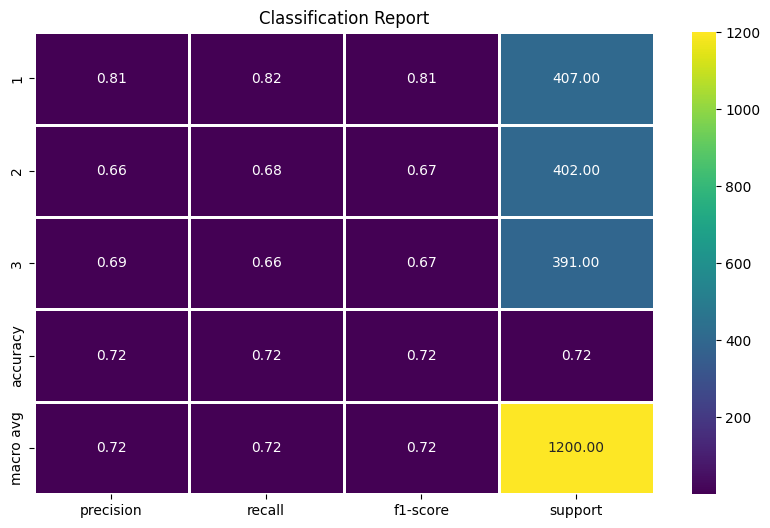

In [23]:
report = classification_report(test_labels, predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap='viridis', fmt=".2f", linewidths=0.8)
plt.title('Classification Report')
plt.show()

In [ ]:
train_texts = train_data['PreprocessedText'].tolist()
train_labels = train_data['TraditionsAnswers'].tolist()
test_texts = test_data['PreprocessedText'].tolist()
test_labels = test_data['TraditionsAnswers'].tolist()
train_texts = np.where(pd.isnull(train_texts), '', train_texts)
test_texts = np.where(pd.isnull(test_texts), '', test_texts)
parameters = {
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
}
decision_tree_classifier = DecisionTreeClassifier(random_state=0)
pipeline_decision_tree = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components=100, random_state=0)),
    ('scaler', StandardScaler()),
    ('minmax_scaler', MinMaxScaler()),
    ('selector', SelectKBest(chi2, k='all')),
    ('clf', decision_tree_classifier)
])
grid_search = GridSearchCV(pipeline_decision_tree, parameters, cv=5, n_jobs=-1)
grid_search.fit(train_texts, train_labels)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
predictions = best_model.predict(test_texts)

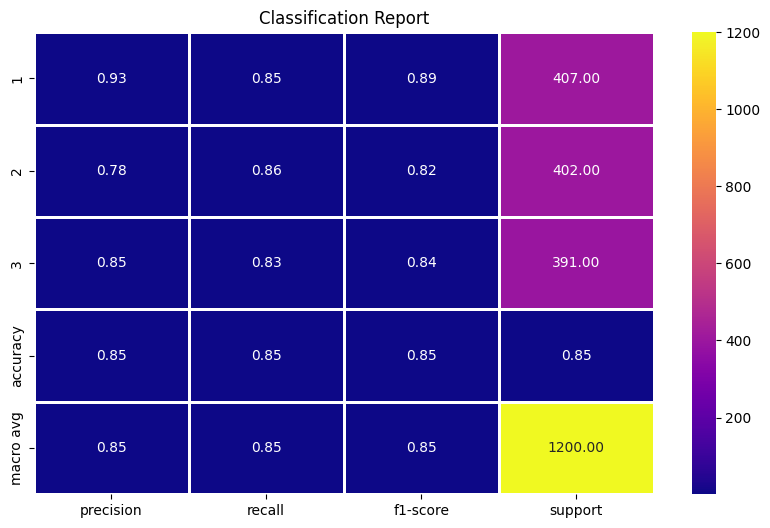

In [65]:
report = classification_report(test_labels, predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap='plasma', fmt=".2f", linewidths=0.8)
plt.title('Classification Report')
plt.show()

In [92]:
train_texts = train_data['PreprocessedText'].tolist()
train_labels = train_data['TraditionsAnswers'].tolist()
test_texts = test_data['PreprocessedText'].tolist()
test_labels = test_data['TraditionsAnswers'].tolist()
train_texts = np.where(pd.isnull(train_texts), '', train_texts)
test_texts = np.where(pd.isnull(test_texts), '', test_texts)
param_grid = {
    'tfidf__max_df': [0.5, 0.75],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svd__n_components': [50, 100],
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10]
}
random_forest = RandomForestClassifier()
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components=100, random_state=0)),
    ('scaler', StandardScaler()),
    ('minmax_scaler', MinMaxScaler()),
    ('selector', SelectKBest(chi2, k='all')),
    ('clf', random_forest)
])
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(train_texts, train_labels)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
predictions = best_model.predict(test_texts)
unlabeled_data = train_data[train_data['TraditionsAnswers'].isnull()]
unlabeled_texts = unlabeled_data['PreprocessedText'].tolist()
unlabeled_texts = np.where(pd.isnull(unlabeled_texts), '', unlabeled_texts)
unlabeled_texts = [preprocess_text(text) for text in unlabeled_texts]
predictions_unlabeled = pipeline.predict(unlabeled_texts)
train_data.loc[train_data['TraditionsAnswers'].isnull(), 'TraditionsAnswers'] = predictions_unlabeled

In [115]:
train_texts = train_data['PreprocessedText'].tolist()
train_labels = train_data['ActivitiesAnswers'].tolist()
test_texts = test_data['PreprocessedText'].tolist()
test_labels = test_data['ActivitiesAnswers'].tolist()
train_texts = np.where(pd.isnull(train_texts), '', train_texts)
test_texts = np.where(pd.isnull(test_texts), '', test_texts)
param_grid = {
    'tfidf__max_df': [0.5, 0.75],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svd__n_components': [50, 100],
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10]
}
random_forest = RandomForestClassifier()
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components=100, random_state=0)),
    ('scaler', StandardScaler()),
    ('minmax_scaler', MinMaxScaler()),
    ('selector', SelectKBest(chi2, k='all')),
    ('clf', random_forest)
])
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(train_texts, train_labels)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
predictions = best_model.predict(test_texts)
unlabeled_data = train_data[train_data['ActivitiesAnswers'].isnull()]
unlabeled_texts = unlabeled_data['PreprocessedText'].tolist()
unlabeled_texts = np.where(pd.isnull(unlabeled_texts), '', unlabeled_texts)
unlabeled_texts = [preprocess_text(text) for text in unlabeled_texts]
predictions_unlabeled = pipeline.predict(unlabeled_texts)
train_data.loc[train_data['ActivitiesAnswers'].isnull(), 'ActivitiesAnswers'] = predictions_unlabeled

In [129]:
train_texts = train_data['PreprocessedText'].tolist()
train_labels = train_data['SightsAnswers'].tolist()
test_texts = test_data['PreprocessedText'].tolist()
test_labels = test_data['SightsAnswers'].tolist()
train_texts = np.where(pd.isnull(train_texts), '', train_texts)
test_texts = np.where(pd.isnull(test_texts), '', test_texts)
param_grid = {
    'tfidf__max_df': [0.5, 0.75],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svd__n_components': [50, 100],
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10]
}
random_forest = RandomForestClassifier()
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components=100, random_state=0)),
    ('scaler', StandardScaler()),
    ('minmax_scaler', MinMaxScaler()),
    ('selector', SelectKBest(chi2, k='all')),
    ('clf', random_forest)
])
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(train_texts, train_labels)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
predictions = best_model.predict(test_texts)

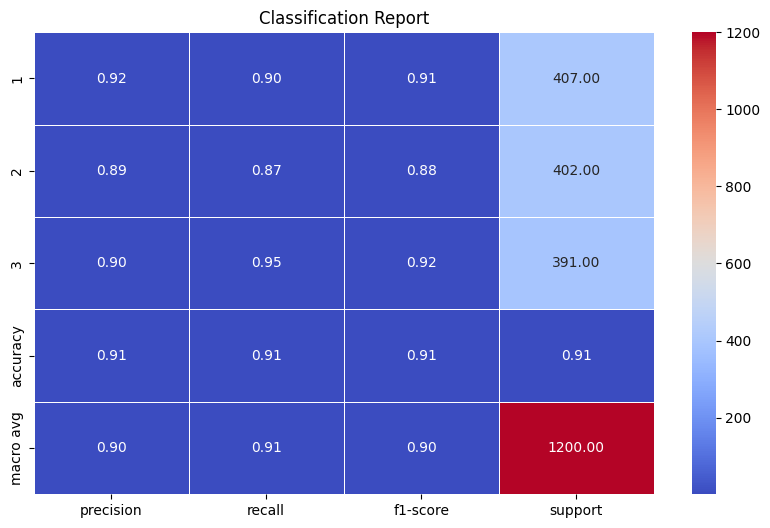

In [130]:
report = classification_report(test_labels, predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Classification Report')
plt.show()

In [ ]:
unlabeled_data = train_data[train_data['SightsAnswers'].isnull()]
unlabeled_texts = unlabeled_data['PreprocessedText'].tolist()
unlabeled_texts = np.where(pd.isnull(unlabeled_texts), '', unlabeled_texts)
unlabeled_texts = [preprocess_text(text) for text in unlabeled_texts]
predictions_unlabeled = pipeline.predict(unlabeled_texts)
train_data.loc[train_data['SightsAnswers'].isnull(), 'SightsAnswers'] = predictions_unlabeled

In [132]:
train_texts = train_data['PreprocessedText'].tolist()
train_labels = train_data['VictoriesAnswers'].tolist()
test_texts = test_data['PreprocessedText'].tolist()
test_labels = test_data['VictoriesAnswers'].tolist()
param_grid = {
    'tfidf__max_df': [0.5, 0.75],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svd__n_components': [50, 100],
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10]
}
random_forest = RandomForestClassifier()
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components=100, random_state=0)),
    ('scaler', StandardScaler()),
    ('minmax_scaler', MinMaxScaler()),
    ('selector', SelectKBest(chi2, k='all')),
    ('clf', random_forest)
])
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(train_texts, train_labels)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
predictions = best_model.predict(test_texts)
unlabeled_data = train_data[train_data['VictoriesAnswers'].isnull()]
unlabeled_texts = unlabeled_data['PreprocessedText'].tolist()
unlabeled_texts = np.where(pd.isnull(unlabeled_texts), '', unlabeled_texts)
unlabeled_texts = [preprocess_text(text) for text in unlabeled_texts]
predictions_unlabeled = pipeline.predict(unlabeled_texts)
train_data.loc[train_data['VictoriesAnswers'].isnull(), 'VictoriesAnswers'] = predictions_unlabeled

In [150]:
train_texts = train_data['PreprocessedText'].tolist()
train_labels = train_data['PersonalityAnswers'].tolist()
test_texts = test_data['PreprocessedText'].tolist()
test_labels = test_data['PersonalityAnswers'].tolist()
param_grid = {
    'tfidf__max_df': [0.5, 0.75],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svd__n_components': [50, 100],
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10]
}
random_forest = RandomForestClassifier()
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components=100, random_state=0)),
    ('scaler', StandardScaler()),
    ('minmax_scaler', MinMaxScaler()),
    ('selector', SelectKBest(chi2, k='all')),
    ('clf', random_forest)
])
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
grid_search.fit(train_texts, train_labels)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
predictions = best_model.predict(test_texts)
unlabeled_data = train_data[train_data['PersonalityAnswers'].isnull()]
unlabeled_texts = unlabeled_data['PreprocessedText'].tolist()
unlabeled_texts = np.where(pd.isnull(unlabeled_texts), '', unlabeled_texts)
unlabeled_texts = [preprocess_text(text) for text in unlabeled_texts]
predictions_unlabeled = pipeline.predict(unlabeled_texts)
train_data.loc[train_data['PersonalityAnswers'].isnull(), 'PersonalityAnswers'] = predictions_unlabeled

In [153]:
def calculate_family_life_index(row):
    return math.floor((row['TraditionsAnswers'] + row['ActivitiesAnswers']) / 2)
def calculate_culture_index(row):
    return math.floor((row['SightsAnswers'] + row['PersonalityAnswers']) / 2)
train.rename(columns={'VictoriesAnswers': 'History Knowledge Index'}, inplace=True)
train['Family Life Index'] = train.apply(calculate_family_life_index, axis=1)
train['Culture Index'] = train.apply(calculate_culture_index, axis=1)

In [183]:
train = train[['Number', 'Class', 'Sex', 'Rus', 'Math', 'Family', 'Region', 'History Knowledge Index', 'Family Life Index', 'Culture Index']]
train.to_excel('data_dima_3families.xlsx')

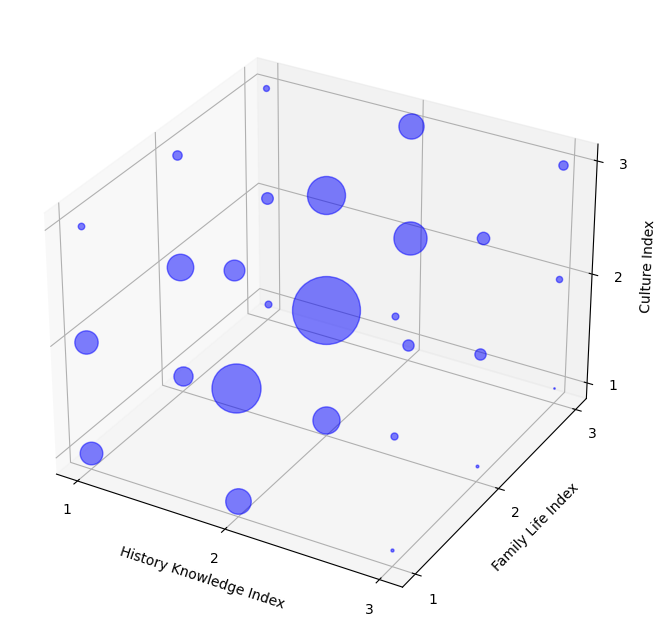

In [160]:
first = train.copy()
x = np.linspace(1, 3, 3)
y = np.linspace(1, 3, 3)
z = np.linspace(1, 3, 3)
X, Y, Z = np.meshgrid(x, y, z)
points = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
grouped_first = first.groupby(['History Knowledge Index', 'Family Life Index', 'Culture Index']).size().reset_index(name='count')
for index, row in grouped_first.iterrows():
    ax.scatter(row['History Knowledge Index'], row['Family Life Index'], row['Culture Index'], s=row['count']*0.2, color='blue', alpha=0.5)  
ax.set_xlabel('History Knowledge Index')
ax.set_ylabel('Family Life Index')
ax.set_zlabel('Culture Index')
ax.set_xticks([1, 2, 3])
ax.set_yticks([1, 2, 3])
ax.set_zticks([1, 2, 3])
plt.show()

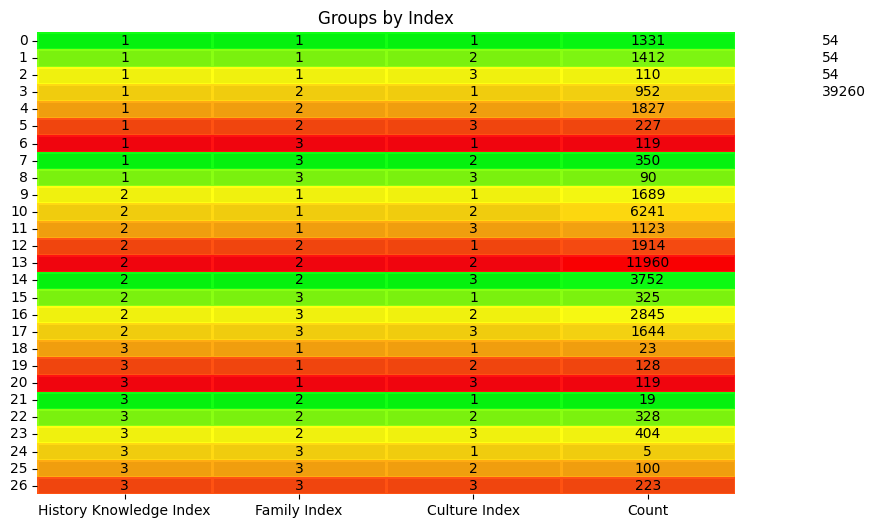

In [162]:
combination_counts = train.groupby(['History Knowledge Index', 'Family Life Index', 'Culture Index']).size().reset_index(name='count')
plt.figure(figsize=(9, 6))
row_colors = ['#00FF00', '#80FF00', '#FFFF00', '#FFD700', '#FFA500', '#FF4500', '#FF0000']
heatmap = sns.heatmap(combination_counts, annot=True, cmap='coolwarm', cbar=False, fmt='d', annot_kws={"fontsize": 10, "color": "black"}, linewidths=1)
for i in range(len(combination_counts)):
    color_index = i % len(row_colors)
    heatmap.axhspan(i, i + 1, facecolor=row_colors[color_index], alpha=0.93)
plt.xticks([])
for i, count in enumerate(combination_counts.sum(axis=0)):
    plt.text(combination_counts.shape[1] + 0.5, i + 0.5, f'{count:.0f}', va='center', ha='left')
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=["History Knowledge Index", "Family Index", "Culture Index", "Count"], rotation=0)
plt.xlabel('')
plt.title('Groups by Index')
plt.show()

In [163]:
train.loc[(train['History Knowledge Index'] == 1) & (train['Family Life Index'] == 1) & (train['Culture Index'] == 3), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [1, 1, 2]
train.loc[(train['History Knowledge Index'] == 1) & (train['Family Life Index'] == 2) & (train['Culture Index'] == 3), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [1, 2, 2]
train.loc[(train['History Knowledge Index'] == 1) & (train['Family Life Index'] == 3) & (train['Culture Index'] == 1), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [1, 2, 1]
train.loc[(train['History Knowledge Index'] == 1) & (train['Family Life Index'] == 3) & (train['Culture Index'] == 2), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [1, 2, 2]
train.loc[(train['History Knowledge Index'] == 1) & (train['Family Life Index'] == 3) & (train['Culture Index'] == 3), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [2, 3, 3]
train.loc[(train['History Knowledge Index'] == 2) & (train['Family Life Index'] == 3) & (train['Culture Index'] == 1), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [2, 3, 2]
train.loc[(train['History Knowledge Index'] == 3) & (train['Family Life Index'] == 1) & (train['Culture Index'] == 1), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [2, 1, 1]
train.loc[(train['History Knowledge Index'] == 3) & (train['Family Life Index'] == 1) & (train['Culture Index'] == 2), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [2, 1, 2]
train.loc[(train['History Knowledge Index'] == 3) & (train['Family Life Index'] == 1) & (train['Culture Index'] == 3), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [3, 3, 3]
train.loc[(train['History Knowledge Index'] == 3) & (train['Family Life Index'] == 2) & (train['Culture Index'] == 1), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [2, 2, 1]
train.loc[(train['History Knowledge Index'] == 3) & (train['Family Life Index'] == 2) & (train['Culture Index'] == 2), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [2, 2, 2]
train.loc[(train['History Knowledge Index'] == 3) & (train['Family Life Index'] == 2) & (train['Culture Index'] == 3), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [3, 3, 3]
train.loc[(train['History Knowledge Index'] == 3) & (train['Family Life Index'] == 3) & (train['Culture Index'] == 1), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [2, 2, 1]
train.loc[(train['History Knowledge Index'] == 3) & (train['Family Life Index'] == 3) & (train['Culture Index'] == 2), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [3, 3, 3]
train.loc[(train['History Knowledge Index'] == 1) & (train['Family Life Index'] == 1) & (train['Culture Index'] == 2), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [1, 1, 1]
train.loc[(train['History Knowledge Index'] == 1) & (train['Family Life Index'] == 2) & (train['Culture Index'] == 2), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [1, 2, 1]
train.loc[(train['History Knowledge Index'] == 2) & (train['Family Life Index'] == 1) & (train['Culture Index'] == 1), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [1, 1, 1]
train.loc[(train['History Knowledge Index'] == 2) & (train['Family Life Index'] == 2) & (train['Culture Index'] == 1), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [2, 2, 2]
train.loc[(train['History Knowledge Index'] == 2) & (train['Family Life Index'] == 1) & (train['Culture Index'] == 3), ['History Knowledge Index', 'Family Life Index', 'Culture Index']] = [2, 2, 3]

Text(0.5, 36.72222222222221, '')

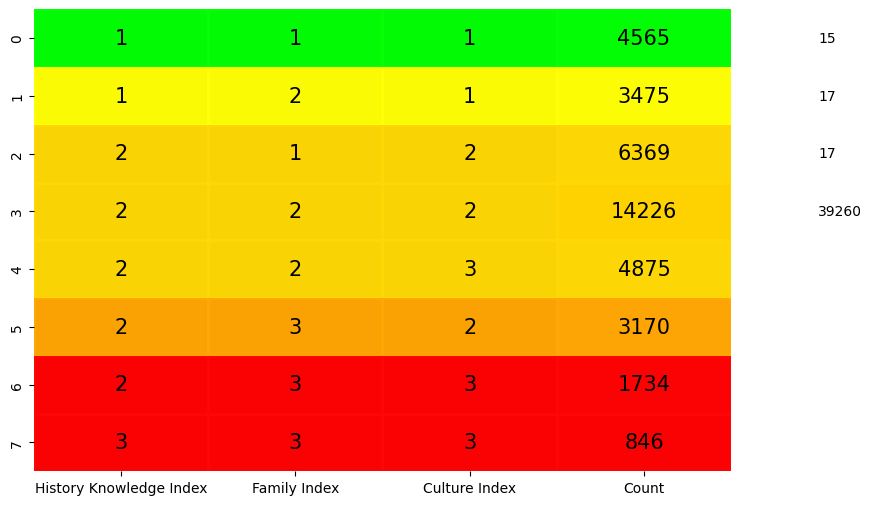

In [165]:
plt.figure(figsize=(9, 6))
row_colors = ['#00FF00', '#FFFF00', '#FFD700', '#FFA500', '#FF0000']
heatmap = sns.heatmap(combination_counts, annot=True, cmap='coolwarm', cbar=False, fmt='d', annot_kws={"fontsize": 15, "color": "black"}, linewidths=1)
for i in range(len(combination_counts)):
    if i == 0:
        color_index = 0
    elif i == 1:
        color_index = 1
    elif i in [2, 3, 4]:
        color_index = 2
    elif i == 5:
        color_index = 3
    elif i in [6, 7]:
        color_index = 4
    heatmap.axhspan(i, i + 1, facecolor=row_colors[color_index], alpha=0.98)
plt.xticks([])
for i, count in enumerate(combination_counts.sum(axis=0)):
    plt.text(combination_counts.shape[1] + 0.5, i + 0.5, f'{count:.0f}', va='center', ha='left')
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=["History Knowledge Index", "Family Index", "Culture Index", "Count"], rotation=0)
plt.xlabel('')

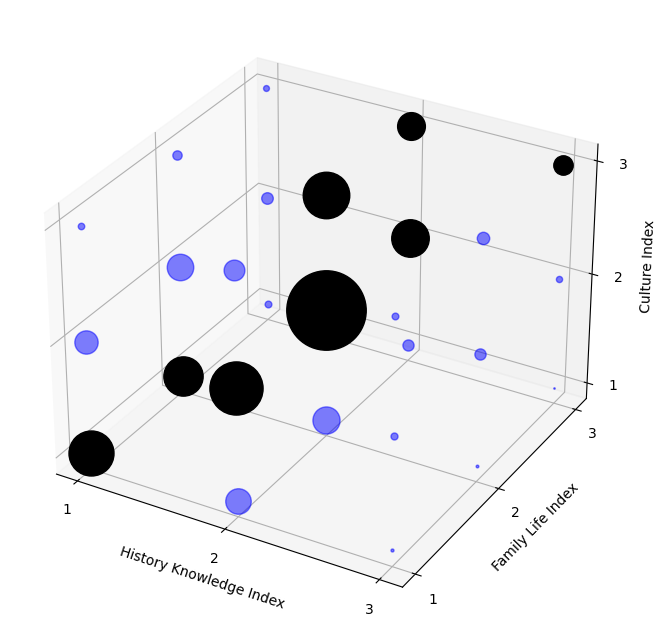

In [167]:
x = np.linspace(1, 3, 3)
y = np.linspace(1, 3, 3)
z = np.linspace(1, 3, 3)
X, Y, Z = np.meshgrid(x, y, z)
points = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
grouped_first = first.groupby(['History Knowledge Index', 'Family Life Index', 'Culture Index']).size().reset_index(name='count')
for index, row in grouped_first.iterrows():
    ax.scatter(row['History Knowledge Index'], row['Family Life Index'], row['Culture Index'], s=row['count']*0.2, color='blue', alpha=0.5)  
grouped_temp = train.groupby(['History Knowledge Index', 'Family Life Index', 'Culture Index']).size().reset_index(name='count')
for index, row in grouped_temp.iterrows():
    ax.scatter(row['History Knowledge Index'], row['Family Life Index'], row['Culture Index'], s=row['count']*0.23, color='black', alpha=1)  
ax.set_xlabel('History Knowledge Index')
ax.set_ylabel('Family Life Index')
ax.set_zlabel('Culture Index')
ax.set_xticks([1, 2, 3])
ax.set_yticks([1, 2, 3])
ax.set_zticks([1, 2, 3])
plt.show()

In [181]:
train.to_excel('classified.xlsx')